# KoT5-Base Basline Train - 4K
- GKSL 4K
- 모듈에서 불러오는 모델 적용

https://github.com/paust-team/pko-t5

## 0. 라이브러리 및 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'pandas'

In [2]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

# KoT5 모델과 토크나이저 로드
model_name = 'paust/pko-t5-base'

tokenizer = T5TokenizerFast.from_pretrained(model_name, force_download=True)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.90M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

In [3]:
# 텍스트를 토큰화하여 입력 ID로 변환
sentence = "가장 가까운 위치로 검색해드리겠습니다"
encoded = tokenizer(sentence)
input_ids = encoded["input_ids"]
print(input_ids)

[985, 222, 3350, 222, 1293, 293, 222, 1759, 322, 2793, 1]


In [4]:
# 만약 개별 토큰을 보고 싶다면, 이 경우에는 바이트로 처리되기 때문에 결과가 깨질 수 있음
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print("Tokens:", tokens)

Tokens: ['ê°Ģìŀ¥', 'Ġ', 'ê°Ģê¹Įìļ´', 'Ġ', 'ìľĦì¹ĺ', 'ë¡ľ', 'Ġ', 'ê²Ģìĥī', 'íķ´', 'ëĵľë¦¬ê²łìĬµëĭĪëĭ¤', '</s>']


In [5]:
# 각 ID를 디코딩하여 개별 토큰이 어떤 텍스트를 나타내는지 확인
individual_decoded_tokens = [tokenizer.decode([id]) for id in input_ids]
print("Individual Decoded Tokens:", individual_decoded_tokens)

Individual Decoded Tokens: ['가장', ' ', '가까운', ' ', '위치', '로', ' ', '검색', '해', '드리겠습니다', '</s>']


In [6]:
tokenizer.decode(encoded['input_ids'], skip_special_tokens=True)

'가장 가까운 위치로 검색해드리겠습니다'

**한글깨짐 문제 **

- 한글이 깨지는 것이 아니라, Byte-level BPE를 사용하여 text를 byte의 sequence로 처리하기에 다음과 같은 토큰들의 결과가 나오는 것
- 해당 출력 토큰의 'input_ids' 값을 tokenizer.decode(string) 하면 해당 결과를 확인

In [7]:
model.config

T5Config {
  "_name_or_path": "paust/pko-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "use_cache": true,
  "vocab_size": 50358
}

In [8]:
model

T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

데이터 불러오기

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL13k_augmented.csv')
df.columns = ['augmentation_method', 'idx', 'gloss', 'text']
df.head(30)

,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
8,SR,9,1호 갈아타다 목적 곳곳,1호선 환승하는 위치는 어디인가요?
9,SR,10,1호 갈아타다 목적 곳곳,1호선 환승하는 장소는 어디인가요?


## 1. 데이터 파악

In [22]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(13047, 11345, 8451)

In [23]:
for i in df.augmentation_method.unique():
  print(i, ':', len(df[df.augmentation_method==i]))

SR : 899
SP : 1494
BR : 10654


In [24]:
# '?'가 포함된 행 제거
print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
df[~df['text'].str.contains('\?')].head(10)

0.6439028129071818


,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
12,SR,13,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,SR,14,도착 3시,3시에 당도합니다.


### 데이터 전처리

In [25]:
df = df[~df['text'].str.contains('\?')]
df = df[['gloss', 'text']]
df.head(30)

,gloss,text
0,집 불,댁에 불이 났어요.
1,집 불,주택에 불이 났어요.
2,집 불,가옥에 불이 났어요.
3,집 불,세대에 불이 났어요.
4,도착 10분 전,10분 내로 당도합니다.
5,도착 10분,10분 뒤에 당도합니다.
6,도착 1시간 전,1시간 내로 당도합니다.
7,도착 1시,1시에 당도합니다.
12,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,도착 3시,3시에 당도합니다.


### 문장 길이 시각화
max_len 설정을 위함

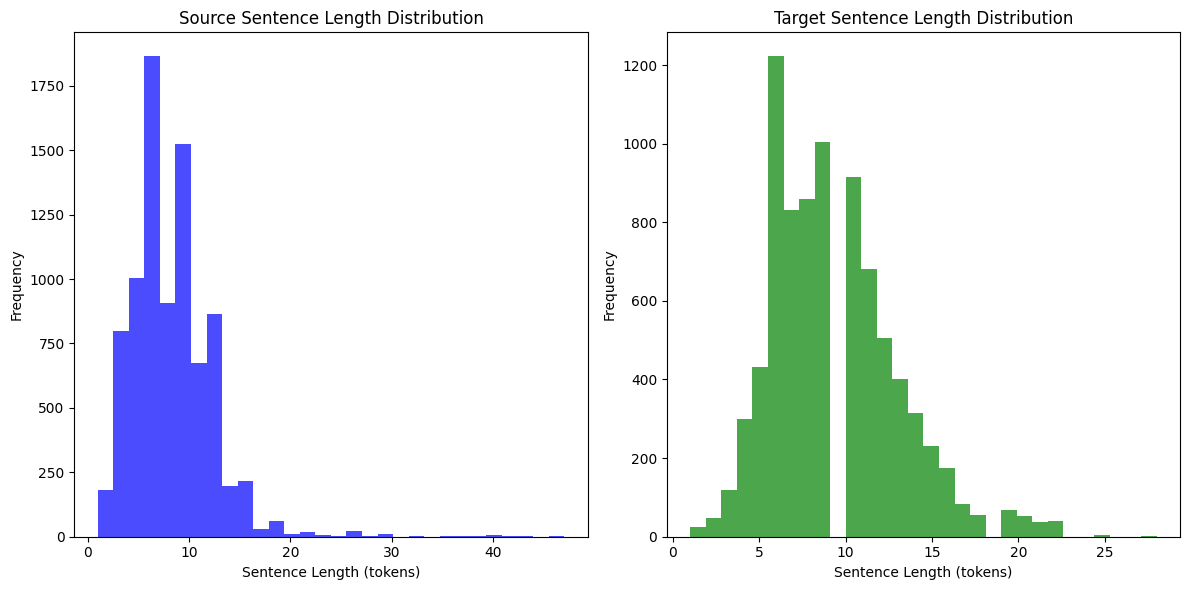

In [26]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    8401.000000
mean        8.338650
std         3.941379
min         1.000000
25%         6.000000
50%         8.000000
75%        11.000000
90%        13.000000
95%        14.000000
99%        20.000000
max        47.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    8401.000000
mean        9.284847
std         3.664686
min         1.000000
25%         6.000000
50%         9.000000
75%        11.000000
90%        14.000000
95%        16.000000
99%        20.000000
max        28.000000
Name: target_len, dtype: float64


## 2. 데이터 로더 생성

In [28]:
from torch.utils.data import Dataset, DataLoader

class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_length=16):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        gloss = self.glosses[idx]
        text = self.texts[idx]

        # 입력(글로스) 토큰화
        inputs = self.tokenizer(gloss, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        # 출력(텍스트) 토큰화
        labels = self.tokenizer(text, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        labels = labels.input_ids.squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [29]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
train_dataset[0]

{'input_ids': tensor([3074,  222, 6459, 2892,  267,  222, 1363,    1,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([ 3074,   291,   222,  6459, 11992,    15,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0])}

## 3. 모델 준비

In [31]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 10

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. KoT5 학습


In [32]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
import tqdm
from tqdm import tqdm

# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 조기 종료 변수 설정
# early_stopping_patience = 5  # 손실 개선이 없을 때 기다리는 에포크 수
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 모델에 데이터 전달
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Validation Loss: {avg_val_loss}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')

    # 조기 종료 확인
   # if avg_val_loss < best_val_loss:
   #     best_val_loss = avg_val_loss
   #     epochs_since_improvement = 0  # 손실 개선이 있으면 카운트 리셋
   # else:
   #     epochs_since_improvement += 1
   #     if epochs_since_improvement >= early_stopping_patience:
   #         print(f"Early stopping triggered. No improvement for {early_stopping_patience} epochs.")
   #         break


Starting epoch 1/10


Validation: 100%|██████████| 53/53 [00:32<00:00,  1.63batch/s]


Epoch 1/10, Loss: 4.902018156789598, Validation Loss: 1.1438574363600533
Checkpoint saved to ./checkpoints/checkpoint_epoch_1.pt

Starting epoch 2/10


Validation: 100%|██████████| 53/53 [00:32<00:00,  1.64batch/s]


Epoch 2/10, Loss: 1.170497620389575, Validation Loss: 0.8550010987047879
Checkpoint saved to ./checkpoints/checkpoint_epoch_2.pt

Starting epoch 3/10


Validation: 100%|██████████| 53/53 [00:30<00:00,  1.74batch/s]


Epoch 3/10, Loss: 0.9126532774595987, Validation Loss: 0.7114173325727571
Checkpoint saved to ./checkpoints/checkpoint_epoch_3.pt

Starting epoch 4/10


Validation: 100%|██████████| 53/53 [00:31<00:00,  1.70batch/s]


Epoch 4/10, Loss: 0.7784917781750361, Validation Loss: 0.6233979053092453
Checkpoint saved to ./checkpoints/checkpoint_epoch_4.pt

Starting epoch 5/10


Validation: 100%|██████████| 53/53 [00:31<00:00,  1.66batch/s]


Epoch 5/10, Loss: 0.6835483720614797, Validation Loss: 0.5656868753568182
Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pt

Starting epoch 6/10


Epoch 6/10:  73%|███████▎  | 308/420 [11:37<04:07,  2.21s/batch]

In [ ]:
# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. test

In [ ]:
# 체크포인트 로드
checkpoint_path = './checkpoints/checkpoint_epoch_2.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import sacrebleu

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in batch['labels']:
            # 패딩 토큰 ID 제외
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f'BLEU score: {bleu_score.score:.4f}')


Evaluating: 100%|██████████| 53/53 [00:57<00:00,  1.09s/it]

BLEU score: 1.5644


In [ ]:
# 기본
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '목 자주 마시고 싶어']


In [ ]:
# 앞 문장과 합성해서 뒷 문장 내용 추출

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []

    for i, sentence in enumerate(sentences):
        if i > 0:
            # 이전 번역된 문장을 참조하지 않고 현재 문장만 입력으로 사용
            combined_sentence = sentences[i-1] + " " + sentence
        else:
            combined_sentence = sentence

        # 토큰화 및 텐서 변환
        inputs = tokenizer(combined_sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '날씨가 더워서 목이 마르고 싶다']


In [ ]:
# context vector 고려해 문장 생성.. -> 해결 미 완료
def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    context_vector = None

    for sentence in sentences:
        # 현재 문장만을 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동하고 Long 타입으로 변환
        input_ids = inputs['input_ids'].to(model.device).long()
        attention_mask = inputs['attention_mask'].to(model.device).long()

        # 문맥 벡터가 있는 경우 이를 입력에 반영
        if context_vector is not None:
            # 문맥 벡터를 추가할 때, 크기를 맞추기 위해 적절히 변환
            context_vector = context_vector.unsqueeze(1)  # [batch_size, 1, hidden_size]

            # 문맥 벡터를 다음 문장의 시작으로 사용 (단일 벡터로 시작 부분을 교체)
            input_ids = torch.cat([context_vector.squeeze(2).long(), input_ids[:, 1:]], dim=1)
            attention_mask = torch.cat([torch.ones_like(context_vector.squeeze(2)), attention_mask[:, 1:]], dim=1)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        context_vector = outputs.encoder_last_hidden_state[:, -1, :]  # 인코더의 마지막 히든 상태를 문맥 벡터로 사용

        # 텍스트 생성
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2